In [1]:
import sys
sys.path.append('./../../designer/script/')
from gets.get_spectrum import get_spectrum_simple
from design import DesignSimple
from film import FilmSimple
from spectrum import SpectrumSimple
from utils.plot_spectrum import plot_spectrum
import numpy as np
import copy
from utils.loss import calculate_RMS
from utils.structure import diff_simple_film
import matplotlib.pyplot as plt

# Initialize: config for TML
WLS = np.linspace(500, 1000, 500)
INC_ANG = 60.
wl = 750. # wl used for calculating OT

def plot_film(f: FilmSimple):
    spec = f.get_spec()
    spec.calculate() # compile cuda kernel func
    plot_spectrum(spec)

np.random.seed(1)
f_target = FilmSimple("SiO2", "TiO2", "SiO2", np.random.random(30) * 100) # target film for TML
f_target.add_spec_param(INC_ANG, WLS)

np.random.seed(1)
f_target_4layers = FilmSimple("SiO2", "TiO2", "SiO2", np.random.random(4) * 750) # target film for TML
f_target_4layers.add_spec_param(INC_ANG, WLS)



In [2]:
# Load trained films data and construct Design objects

def load_designs(file_dir, f_target):
    designs: list[DesignSimple] = []
    for run_idx in range(200):
        try:
            design = DesignSimple(f_target,
                                FilmSimple("SiO2",
                                            "TiO2",
                                            "SiO2",
                                            np.loadtxt(file_dir + f'run_{run_idx}/iter_0')*1000.
                                            ), # init film
                                FilmSimple('SiO2', 
                                            'TiO2',
                                            'SiO2',
                                            np.loadtxt(file_dir + f'run_{run_idx}/final')*1000.
                                            )  # final film
                                )
            design.film.add_spec_param(inc_ang=INC_ANG, wls=WLS)
            design.film.calculate_spectrum()
            design.calculate_loss()

            designs.append(design)
        except Exception as e:
            print(e, f"(run {run_idx})")
            continue # skip invalid d
    return designs


load_file_dir_SiO2 = './../raw_design_result/50iters_0to2OT_200run_SiO2/'
load_file_dir_TiO2 = './../raw_design_result/50iters_0to2OT_200run_TiO2/'
load_file_dir_SiO2_target_4layers = './../raw_design_result/50iters_0to2OT_200run_SiO2_target4layers/'

designs = load_designs(load_file_dir_SiO2_target_4layers, f_target_4layers)

Should be 1 dim array! (run 0)


c:\Users\rfeng6\.conda\envs\cuda\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 32 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [4]:
def get_similarity_matrix(design_list):
    n = len(design_list)
    sim_arr = np.empty((n, n))
    # this takes ~ 30s to run for n=200
    for i in range(n):
        for j in range(n):
            sim_arr[i, j] = diff_simple_film(designs[i].film, designs[j].film, metric='abs')
    return sim_arr


arr = get_similarity_matrix(designs) # time: about 1min


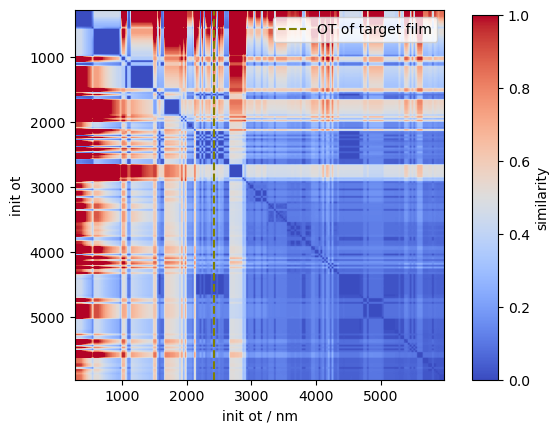

In [9]:
def plot_similarity_matrix(arr, designs: list[FilmSimple]):
    wl = 750
    fig, ax = plt.subplots(1, 1)
    im = ax.imshow(arr,
                    aspect='equal', 
                    extent=(designs[0].get_init_ot(wl),
                            designs[-1].get_init_ot(wl),
                            designs[-1].get_init_ot(wl),
                            designs[0].get_init_ot(wl)
                    ),
                    cmap='coolwarm',
                    vmax=1
            )
    ax.set_xlabel('init ot / nm')
    ax.set_ylabel('init ot')

    # show target ot
    wl = 750
    target_ot = designs[0].get_target_ot(wl)
    ax.plot([target_ot, target_ot], ax.get_ylim(), label='OT of target film', c='olive', ls='--')
    ax.legend()

    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.82, 0.11, 0.04, 0.76])
    fig.colorbar(im, cax=cbar_ax, label='similarity')
    return fig, ax

fig, ax = plot_similarity_matrix(arr, designs)
# fig.savefig("./figs/similarity_matrix.png", dpi=300)